In [2]:
import os
#from google.colab import drive

import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate


#drive.mount('/content/drive')

#os.chdir("/content/drive/MyDrive/Introduction to Intelligent Computing/Final")
print(os.getcwd())

C:\Users\Kn\Downloads\Final_0102\Final


In [3]:
# trainX = np.load('trainX_all.npy')  
# trainY = np.load('trainY_all.npy')

# # shuffle
# idx = np.arange(trainX.shape[0])
# np.random.shuffle(idx)
# trainX = trainX[idx]
# trainY = trainY[idx]

# print('trainX: ', trainX.shape)
# print('trainY: ', trainY.shape)
# print(trainX.dtype)

### Define model structure

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=2):
	# ========Class label============================
	# label input
	# embedding for categorical input
	# scale up to image dimensions with linear activation
	# reshape to additional channel
	in_label = Input(shape=(1,))             
	li = Embedding(n_classes, 50)(in_label)       
	n_nodes = in_shape[0] * in_shape[1]         
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  

	# ========Input image============================
	in_image = Input(shape=in_shape)   
	
	# ========Image+label============================
	merge = Concatenate()([in_image, li])   
	
	# ========Convolution============================
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #downsample(32x32)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)  #downsample(16x16)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)  #downsample(8x8)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe) 
	fe = Dropout(0.4)(fe)
	
	# ========Output layer============================
	out_layer = Dense(1, activation='sigmoid')(fe) 

	# ========Construct============================
	model = Model([in_image, in_label], out_layer) 
	
	# ========Compile============================
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


# define the standalone generator model
def define_generator(latent_dim, n_classes=2):
	# ========Class label============================
	# label input
	# embedding for categorical input
	# linear multiplication
	# reshape to additional channel
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 20)(in_label)
	n_nodes = 8 * 8
	li = Dense(n_nodes)(li)
	li = Reshape((8, 8, 1))(li)
 
	# ========Input image============================
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 8 * 8   #foundation for 8x8 image
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen)
	
	# ========Image+label============================
	merge = Concatenate()([gen, li])
 
	# ========Convolution============================
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) # upsample to 16x16
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) # upsample to 32x32
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) # upsample to 64x64
	gen = LeakyReLU(alpha=0.2)(gen)
 
	# ========Output layer============================
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)
 
	# ========Construct============================
	model = Model([in_lat, in_label], out_layer)
	return model


# in order to update the generator performance
def define_gan(g_model, d_model):
	d_model.trainable = False #since don't need to update discriminator weight
	
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	
	# ========Image+label as inputs to discriminator============================
	gan_output = d_model([gen_output, gen_label])
 
	# ========Construct============================
	model = Model([gen_noise, gen_label], gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [5]:
# load fashion mnist images
def load_real_samples():
  trainX = np.load('trainX_all.npy')  
  trainY = np.load('trainY_all.npy')

  # shuffle
  idx = np.arange(trainX.shape[0])
  np.random.shuffle(idx)
  trainX = trainX[idx]
  trainY = trainY[idx]
  
  trainX = trainX.astype('float32')
  trainX = (trainX - 127.5) / 127.5
  return [trainX, trainY]

In [6]:
def generate_real_samples(dataset, n_samples):
	# random select 'n_sampels' real samples
	# get image+class label
	# denoted as REAL
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y


def generate_latent_points(latent_dim, n_samples, n_classes=2):
	# generate points in the latent space as input for the generator
	x_input = randn(latent_dim * n_samples)  
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]


def generate_fake_samples(generator, latent_dim, n_samples):
	# call generate_latent_points() to generate points as generator's input data
	# use generator ti generate 'n_samples' output images
	# Denoted as FAKE
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y  

In [7]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=150, n_batch=128):
	# train the generator and discriminator
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			# get randomly selected 'real' images
			# update discriminator model weights
			# generate 'fake' images
			# update discriminator model weights
			# prepare points in latent space as input for the generator
			# (GAN)update the generator via the discriminator's error
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))  # Denoted as TRUE for the fake samples
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')


In [8]:
latent_dim = 100  # size of the latent space
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()


c:\users\kn\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/141, d1=0.717, d2=0.695 g=0.692
>1, 2/141, d1=0.540, d2=0.697 g=0.690
>1, 3/141, d1=0.411, d2=0.702 g=0.686
>1, 4/141, d1=0.282, d2=0.712 g=0.676
>1, 5/141, d1=0.190, d2=0.732 g=0.659
>1, 6/141, d1=0.118, d2=0.770 g=0.635
>1, 7/141, d1=0.081, d2=0.818 g=0.620
>1, 8/141, d1=0.064, d2=0.834 g=0.661
>1, 9/141, d1=0.078, d2=0.724 g=0.832
>1, 10/141, d1=0.077, d2=0.563 g=1.019
>1, 11/141, d1=0.082, d2=0.524 g=0.985
>1, 12/141, d1=0.058, d2=0.556 g=0.892
>1, 13/141, d1=0.049, d2=0.599 g=0.813
>1, 14/141, d1=0.034, d2=0.629 g=0.772
>1, 15/141, d1=0.025, d2=0.650 g=0.747
>1, 16/141, d1=0.010, d2=0.675 g=0.728
>1, 17/141, d1=0.011, d2=0.718 g=0.694
>1, 18/141, d1=0.008, d2=0.779 g=0.651
>1, 19/141, d1=0.007, d2=0.825 g=0.637
>1, 20/141, d1=0.012, d2=0.810 g=0.681
>1, 21/141, d1=0.012, d2=0.691 g=0.834
>1, 22/141, d1=0.011, d2=0.526 g=1.073
>1, 23/141, d1=0.010, d2=0.465 g=1.123
>1, 24/141, d1=0.017, d2=0.489 g=1.028
>1, 25/141, d1=0.014, d2=0.530 g=0.935
>1, 26/141, d1=0.006, d2=0.547 g=0

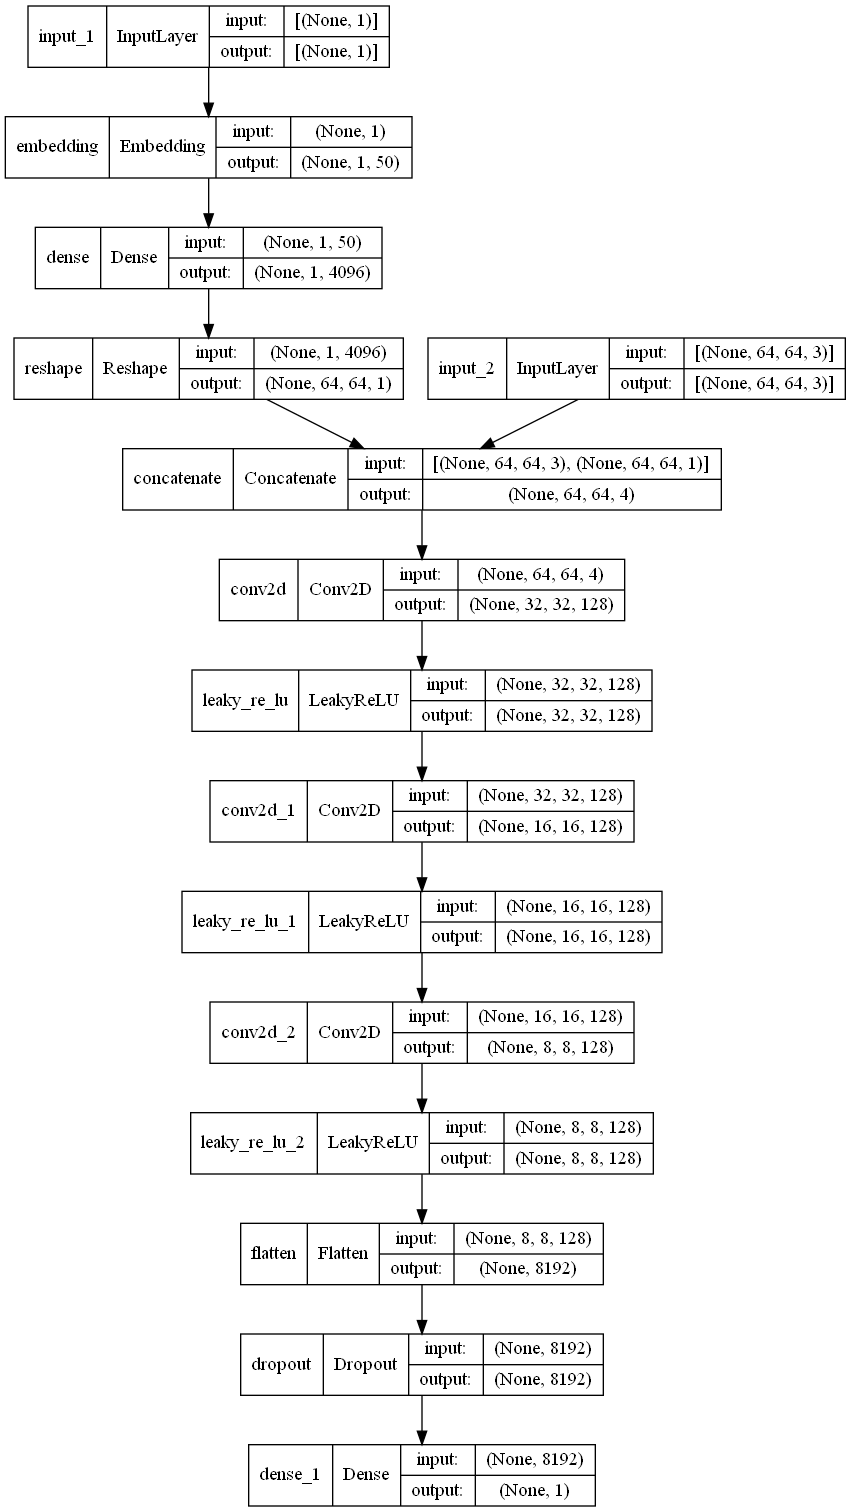

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# d_model.summary()
plot_model(d_model, to_file='d_model.png', show_shapes=True, show_layer_names=True)

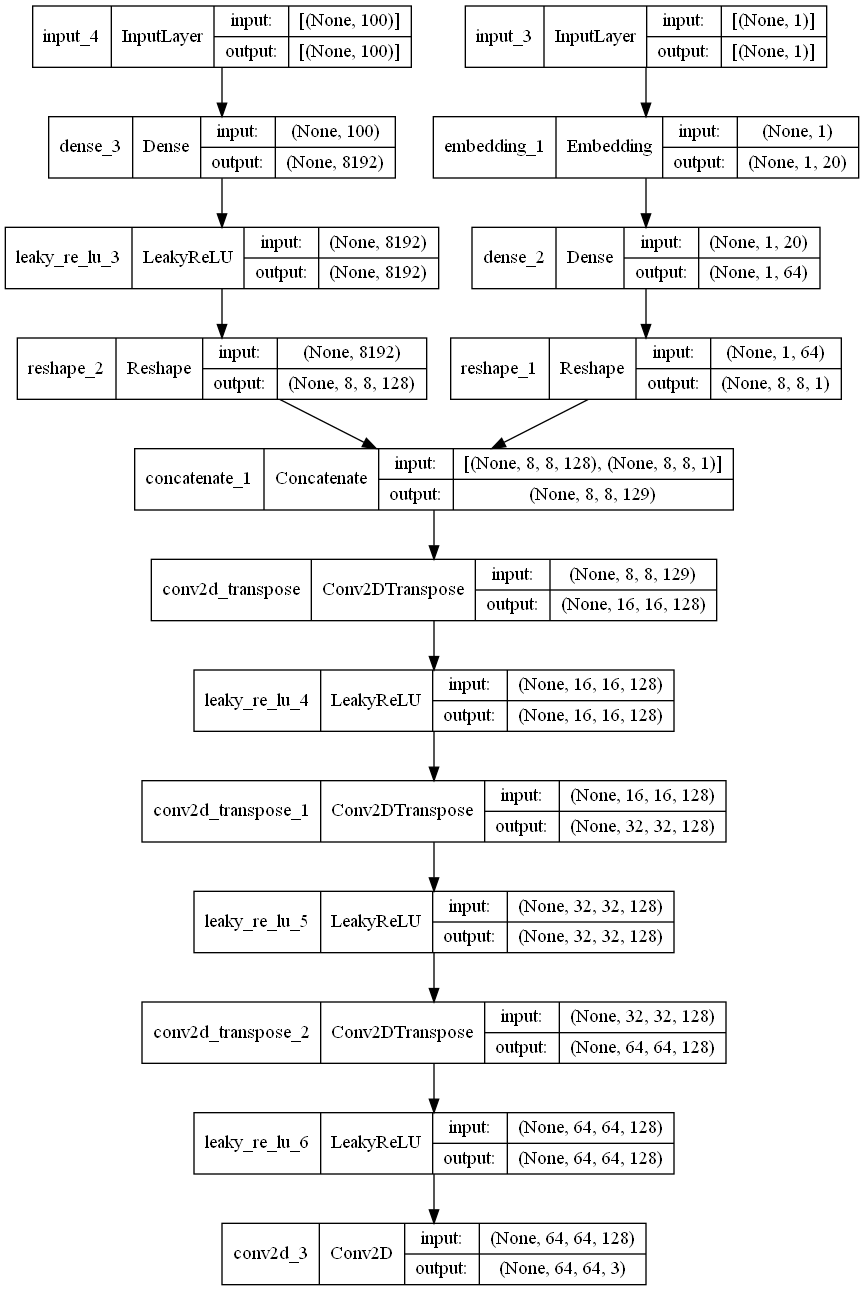

In [11]:
# g_model.summary()
plot_model(g_model, to_file='g_model.png', show_shapes=True, show_layer_names=True)

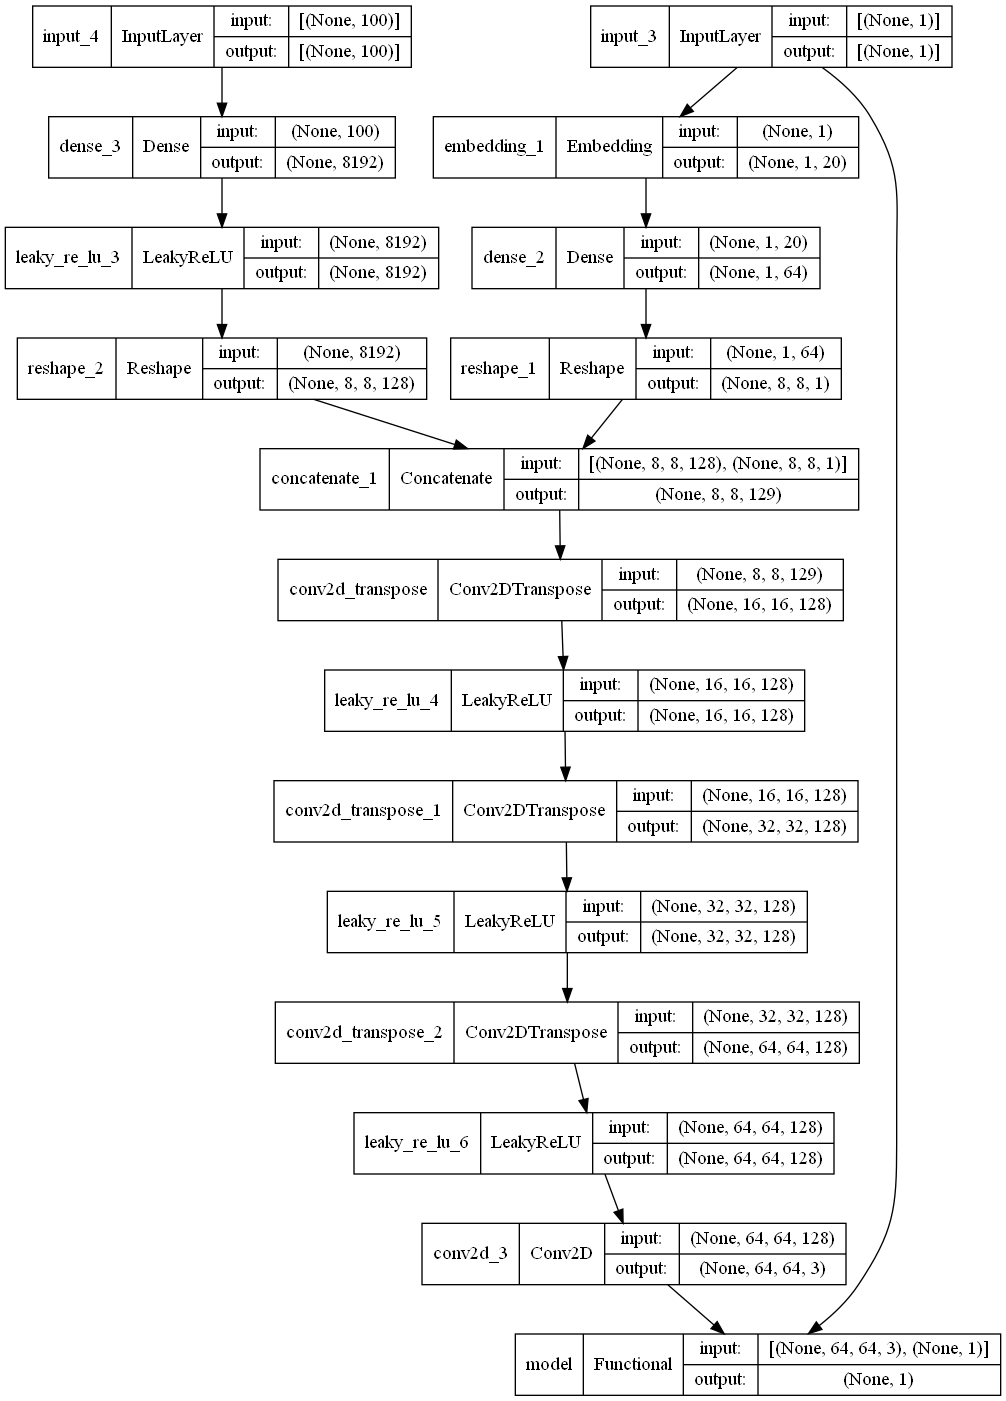

In [12]:
# gan_model.summary()
plot_model(gan_model, to_file='gan_model.png', show_shapes=True, show_layer_names=True)

### Example of loading the generator model and generating images

(100, 64, 64, 3)


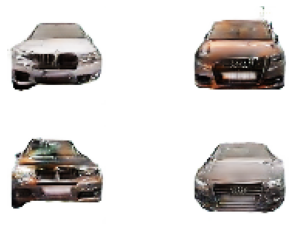

./output/BMW/1.jpg
./output/Audi/1.jpg
./output/BMW/2.jpg
./output/Audi/2.jpg
./output/BMW/3.jpg
./output/Audi/3.jpg
./output/BMW/4.jpg
./output/Audi/4.jpg
./output/BMW/5.jpg
./output/Audi/5.jpg
./output/BMW/6.jpg
./output/Audi/6.jpg
./output/BMW/7.jpg
./output/Audi/7.jpg
./output/BMW/8.jpg
./output/Audi/8.jpg
./output/BMW/9.jpg
./output/Audi/9.jpg
./output/BMW/10.jpg
./output/Audi/10.jpg


In [13]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
import cv2

import matplotlib

def generate_latent_points(latent_dim, n_samples, n_classes=2):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]


def save_plot(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
		# pyplot.imshow(cv2.cvtColor(examples[i], cv2.COLOR_BGR2RGB))
	pyplot.show()


def save_img(examples, n):
	for i in range(20):  # range(n*n)
		# i = int(i)
		path_BMW = "./output/BMW/"
		path_Audi = "./output/Audi/"
		# print(int(i))
		if int(i)%2==0:
			tmp = i / 2
			tmp = int(tmp) + 1
			fname = str(tmp) + ".jpg"
			print(path_BMW+fname)
			matplotlib.image.imsave(path_BMW+fname, examples[i])
		else:
			tmp = (i+1) / 2
			tmp = int(tmp)
			fname = str(tmp) + ".jpg"
			print(path_Audi+fname)
			matplotlib.image.imsave(path_Audi+fname, examples[i])
		# if int(i) < n:
		# 	i = i / 2
		# 	i = int(i)
		# 	fname = str(i) + ".jpg"
		# 	# print(path_BMW+fname)
		# 	matplotlib.image.imsave(path_BMW+fname, examples[i])
		# else:
		# 	i = (i+1) / 2
		# 	i = int(i)
		# 	fname = str(i) + ".jpg"
		# 	# print(path_Audi+fname)
		# 	matplotlib.image.imsave(path_Audi+fname, examples[i])

			

model = load_model('cgan_generator.h5')
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(50) for x in range(2)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
print(X.shape)
save_plot(X, 2)
save_img(X, 2)